In [150]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
data = pd.read_csv('data/daily_close.csv', index_col=[0])

In [188]:
def e_t(ticker1, ticker2, data, verbose = False):
    S1 = data[ticker1]
    S2 = data[ticker2]
    X = sm.add_constant(S2)
    model = sm.OLS(S1, X).fit()
    if verbose:
        print(f"100 * {ticker1} - {int(100 * (model.params[1]))}*{ticker2}")
    residuals = model.resid
    return residuals[-1]

In [189]:
e_t('APOLLOHOSP','SUNPHARMA', data[:int(len(data)*0.7)], verbose=True)

100 * APOLLOHOSP - 560*SUNPHARMA


-646.6967898669573

In [176]:
t_values = range(0, len(data) - int(len(data)*0.7))
et_values = []
dates = []

for t in t_values:
    et_values.append(e_t('APOLLOHOSP','SUNPHARMA', data[:int(len(data)*0.7) + t]))
    dates.append(data[:int(len(data)*0.7) + t].index[-1])

In [154]:
def plot_et(ticker1, ticker2, data):
    t_values = range(0, len(data) - int(len(data)*0.7))
    et_values = []
    dates = []
    
    for t in t_values:
        et_values.append(e_t(ticker1, ticker2, data[:int(len(data)*0.7) + t]))
        dates.append(data[:int(len(data)*0.7) + t].index[-1])
        
    plt.figure(figsize=(12, 8))
    plt.plot(dates, et_values)
    plt.xlabel('time')
    plt.ylabel('e_t Value')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.xticks(dates[::len(dates)//50])
    plt.tight_layout()
    plt.show()

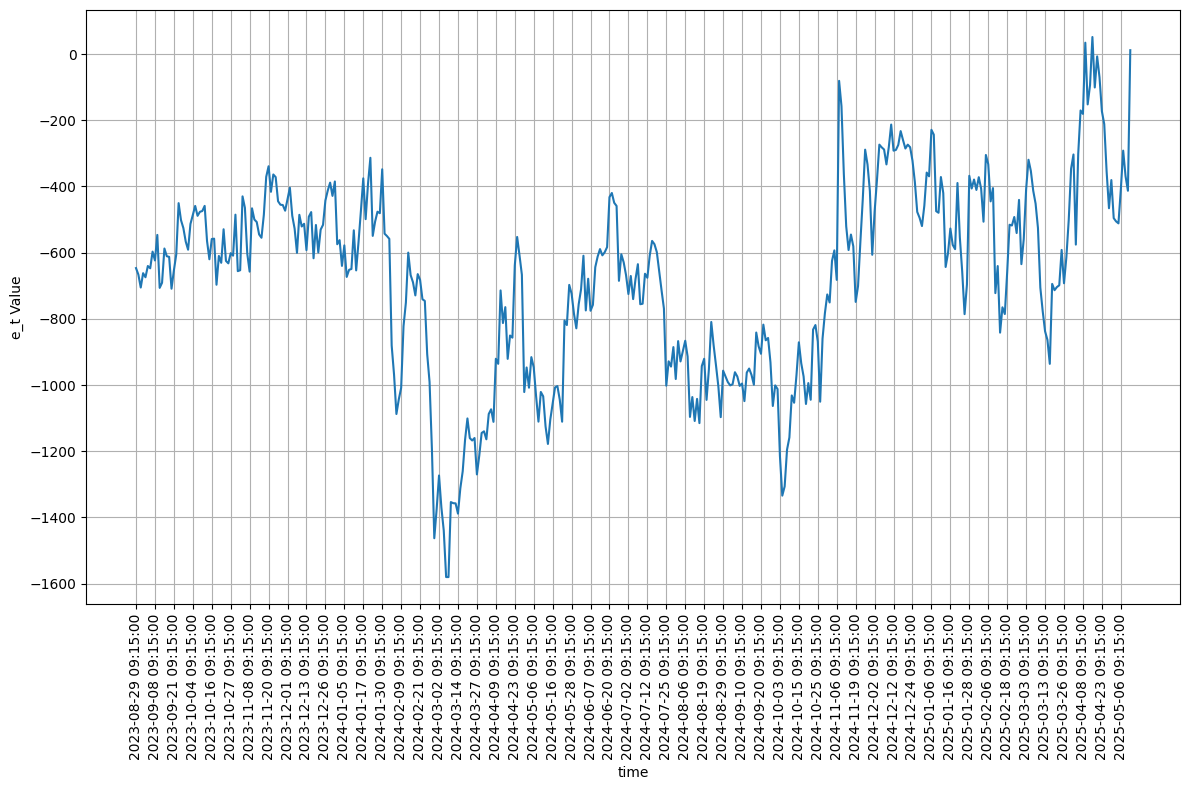

In [155]:
plot_et('APOLLOHOSP','SUNPHARMA', data)

In [156]:
def get_polynomial_slope(et_values, dates, closness):
    degree = min(int(len(dates) / closness) + 1, len(dates)-1)
    x = np.arange(len(dates))
    y = np.array(et_values)
    
    coeffs = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coeffs)
    
    slope = polynomial.deriv()(x[-1])    
    return slope


In [157]:
def make_slope_curve(et_values, dates, closness):
    slopes = []
    for i in range(10, len(et_values)):
        slope = get_polynomial_slope(et_values[0:i], dates[0:i], closness)
        slopes.append(slope)
    plt.figure(figsize=(12, 8))
    plt.plot(dates[10:], slopes)
    plt.xlabel('time')
    plt.ylabel('Slope Value')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.xticks(dates[::len(dates)//50])
    plt.tight_layout()
    plt.show()


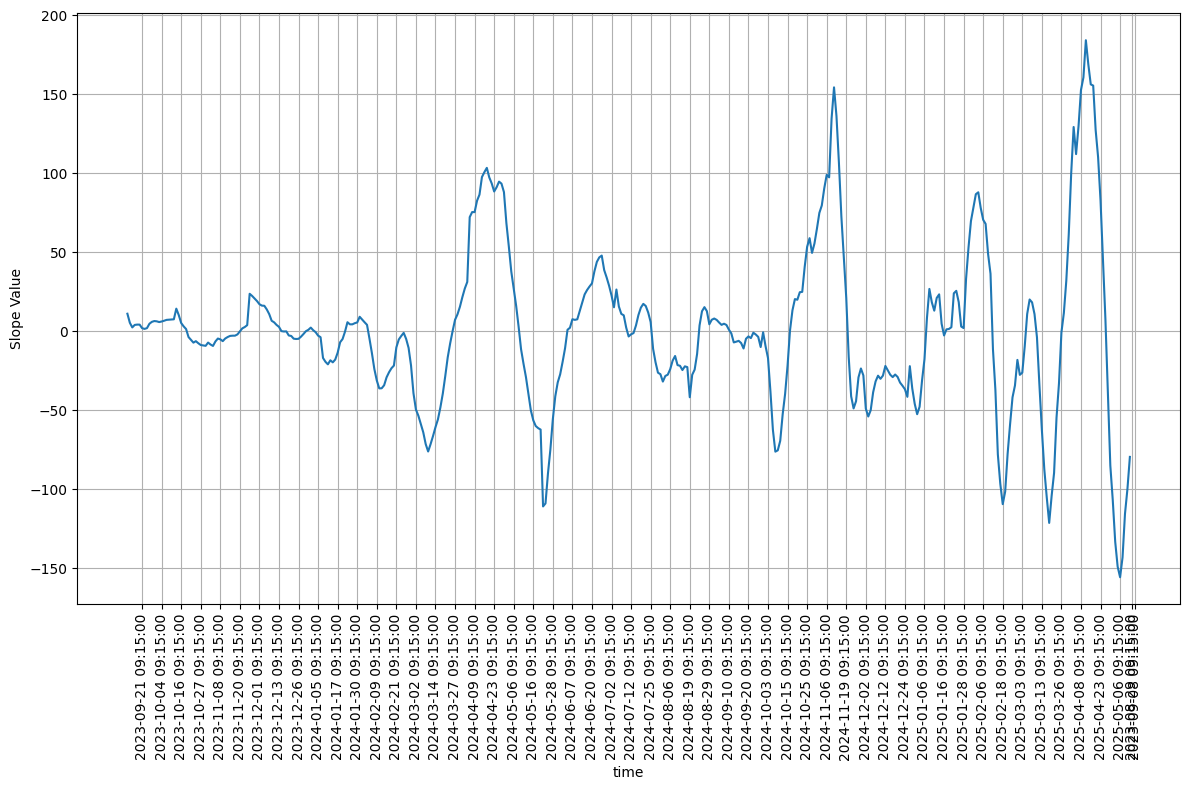

In [158]:
make_slope_curve(et_values, dates, 30)

In [159]:
def get_signals(et_values, dates, closness):
    slopes = []
    signals = []
    for i in range(10, len(et_values)):
        slope = get_polynomial_slope(et_values[0:i], dates[0:i], closness)
        if len(slopes) > 0:
            if slopes[-1] > 0 and slope < 0:
                signals.append((dates[i], "buy", et_values[i]))
            if slopes[-1] < 0 and slope > 0:
                signals.append((dates[i], "sell", et_values[i]))
        slopes.append(slope)
    return signals

In [160]:
signals = get_signals(et_values, dates, 30)

In [190]:
signals

[('2023-10-19 09:15:00', 'buy', -609.8893127236979),
 ('2023-11-21 09:15:00', 'sell', -416.1242352983418),
 ('2023-12-15 09:15:00', 'buy', -477.4084319687827),
 ('2024-01-01 09:15:00', 'sell', -384.9137259501149),
 ('2024-01-04 09:15:00', 'buy', -640.0378051778052),
 ('2024-01-23 09:15:00', 'sell', -549.3329211002801),
 ('2024-02-06 09:15:00', 'buy', -968.6339178639282),
 ('2024-03-26 09:15:00', 'sell', -1160.165918102205),
 ('2024-05-09 09:15:00', 'buy', -1021.002215757766),
 ('2024-06-05 09:15:00', 'sell', -774.6343876840565),
 ('2024-07-11 09:15:00', 'buy', -663.7148520585333),
 ('2024-07-16 09:15:00', 'sell', -564.5491923024119),
 ('2024-07-26 09:15:00', 'buy', -928.3813695309818),
 ('2024-08-23 09:15:00', 'sell', -880.1737994332698),
 ('2024-09-11 09:15:00', 'buy', -1048.663901198558),
 ('2024-10-16 09:15:00', 'sell', -934.1127233952702),
 ('2024-11-21 09:15:00', 'buy', -700.8871724969204),
 ('2025-01-07 09:15:00', 'sell', -243.44303380568817),
 ('2025-01-16 09:15:00', 'buy', -527

In [200]:
for date, signal, _ in signals:
    if signal == "buy":
        print(f"buy at {data['APOLLOHOSP'].loc[date]} of S1 on {date}")
        print(f"sell at {data['SUNPHARMA'].loc[date]} of S2 on {date}")
    if signal == "sell":
        print(f"sell {data['APOLLOHOSP'].loc[date]} of S1 on {date}")
        print(f"buy at {data['SUNPHARMA'].loc[date]} of S2 on {date}")

buy at 4997.0498 of S1 on 2023-10-19 09:15:00
sell at 1141.5 of S2 on 2023-10-19 09:15:00
sell 5466.7998 of S1 on 2023-11-21 09:15:00
buy at 1201.4 of S2 on 2023-11-21 09:15:00
buy at 5551.2002 of S1 on 2023-12-15 09:15:00
sell at 1235.75 of S2 on 2023-12-15 09:15:00
sell 5750.0498 of S1 on 2024-01-01 09:15:00
buy at 1260.25 of S2 on 2024-01-01 09:15:00
buy at 5762.2002 of S1 on 2024-01-04 09:15:00
sell at 1312.95 of S2 on 2024-01-04 09:15:00
sell 6153.75 of S1 on 2024-01-23 09:15:00
buy at 1378.3 of S2 on 2024-01-23 09:15:00
buy at 6197.2998 of S1 on 2024-02-06 09:15:00
sell at 1475.1 of S2 on 2024-02-06 09:15:00
sell 6322.4502 of S1 on 2024-03-26 09:15:00
buy at 1598.1 of S2 on 2024-03-26 09:15:00
buy at 5806.3999 of S1 on 2024-05-09 09:15:00
sell at 1494.65 of S2 on 2024-05-09 09:15:00
sell 5934.6499 of S1 on 2024-06-05 09:15:00
buy at 1487.3 of S2 on 2024-06-05 09:15:00
buy at 6389.0498 of S1 on 2024-07-11 09:15:00
sell at 1581.75 of S2 on 2024-07-11 09:15:00
sell 6453.7002 of S1 o